# Plotting full data

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from CSV files
test = pd.read_csv("/Users/akseljoonas/Downloads/lol_inter_cbrt_features.csv")
train = pd.read_csv(
    "/Users/akseljoonas/Documents/mlfortnight/data/raw/train.csv"
)


In [ ]:

from statsmodels.tsa.stattools import acf
import numpy as np

columns_to_average = [
    "source_1_temperature",
    "source_4_temperature",
    "source_3_temperature",
    "source_2_temperature",
    "sun_radiation_east",
    "sun_radiation_south",
    "mean_room_temperature",
    "outside_temperature",
    "sun_radiation_west",
    "sun_radiation_north",
]

# Define the spans for the moving averages
spans = [12,14,15,16,17,18,19,20,25,26,27,28,29,30,31,32,33,34,35,36,40,]

# Create a dictionary to store autocorrelation results
autocorrelation_results = {}

# Perform grid search for autocorrelation
for column in columns_to_average:
    for span in spans:
        # Create moving average
        train[f"{column}_ema{span}"] = train[column].ewm(span=span, adjust=False).mean()
        
        # Shift the target column by -1 to measure autocorrelation at time t+1
        target_shifted = train['target'].shift(-1)
        
        # Drop NaN values resulting from the shift
        valid_indices = ~np.isnan(target_shifted)
        
        # Calculate autocorrelation with the shifted target
        autocorr = acf(train.loc[valid_indices, f"{column}_ema{span}"], 
                       nlags=1, fft=False)[1]
        
        # Store the result
        autocorrelation_results[f"{column}_ema{span}"] = autocorr

# Print the autocorrelation results sorted by value
for key, value in sorted(autocorrelation_results.items(), key=lambda item: item[1]):
    print(f"Autocorrelation between {key} and target at t+1: {value}")



In [ ]:
# ... existing code ...

# Find the column with the highest autocorrelation
best_autocorrelated_column = max(
    autocorrelation_results, key=autocorrelation_results.get
)

# Limit the data to the first 1000 IDs
train_limited = train[1000:2000]

# Plot the best autocorrelated moving average together with the target column
plt.figure(figsize=(10, 6))

# Plot target column
plt.plot(train_limited["ID"], train_limited["target"], label="Target", color="blue")

# Plot the best autocorrelated moving average
plt.plot(
    train_limited["ID"],
    train_limited[best_autocorrelated_column],
    label=f"Best Autocorrelated: {best_autocorrelated_column}",
    color="red",
)

plt.xlabel("ID")
plt.ylabel("Values")
plt.title("Best Autocorrelated Moving Average and Target Plot")
plt.legend()
plt.show()

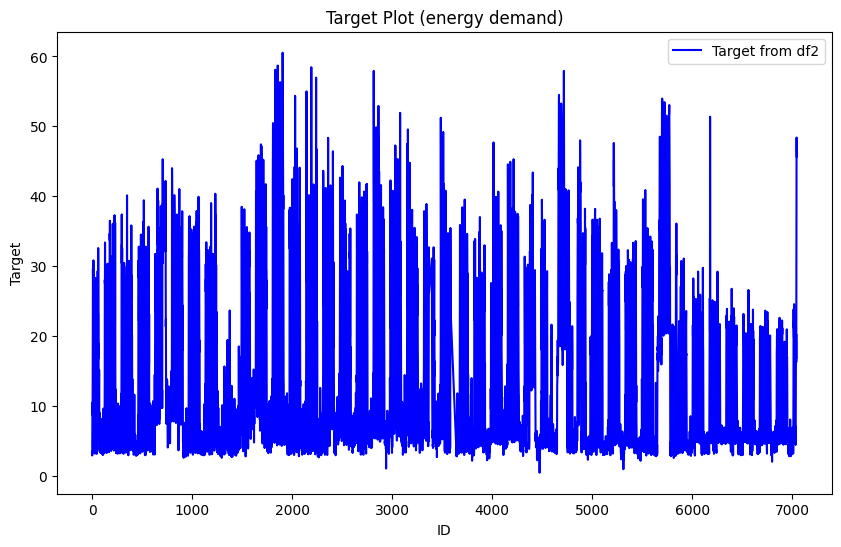

In [5]:
# Plot df2 from index 0 to 2000
plt.figure(figsize=(10, 6))
plt.plot(train["ID"], train["target"], label="Target from df2", color="blue")
plt.xlabel("ID")

plt.ylabel("Target")
plt.title("Target Plot (energy demand)")
plt.legend()
plt.show()

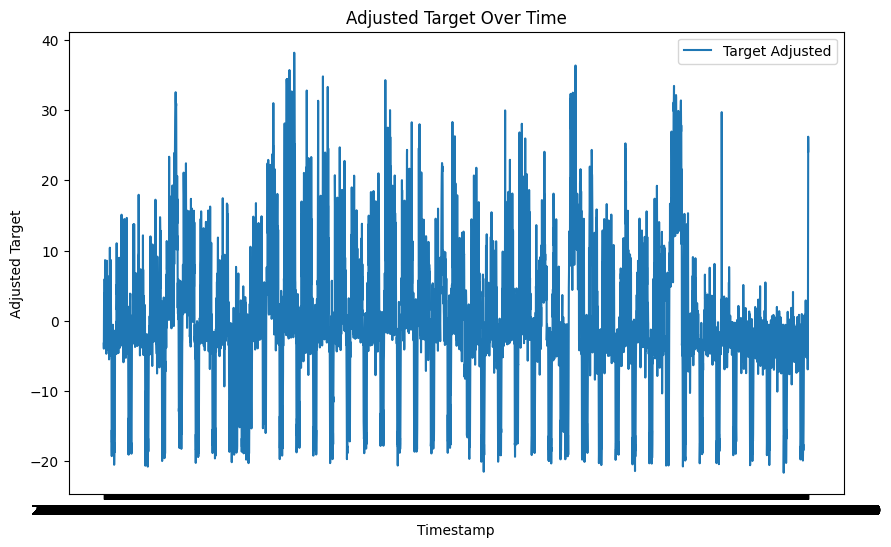

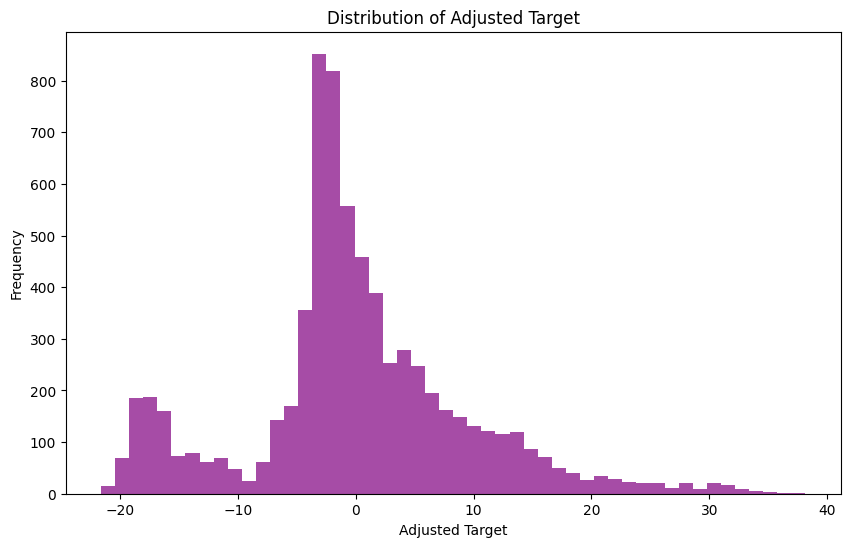

In [10]:
# SEASONALITY REMOVAL
train["hour"] = pd.to_datetime(train["measurement_time"]).dt.hour
train["day"] = pd.to_datetime(train["measurement_time"]).dt.dayofweek

# Calculate the mean for each hour and day
hourly_means = train.groupby("hour")["target"].mean()
daily_means = train.groupby("day")["target"].mean()

# Adjust the target by subtracting the hourly and daily means
train["target_adjusted"] = train.apply(
    lambda row: row["target"] - hourly_means[row["hour"]] - daily_means[row["day"]],
    axis=1,
)

# Plot the adjusted target over time
plt.figure(figsize=(10, 6))
plt.plot(train["measurement_time"], train["target_adjusted"], label="Target Adjusted")
plt.xlabel("Timestamp")
plt.ylabel("Adjusted Target")
plt.title("Adjusted Target Over Time")
plt.legend()
plt.show()

# Plot the distribution of the adjusted target
plt.figure(figsize=(10, 6))
plt.hist(train["target_adjusted"], bins=50, color="purple", alpha=0.7)
plt.xlabel("Adjusted Target")
plt.ylabel("Frequency")
plt.title("Distribution of Adjusted Target")
plt.show()